# 8章　二値分類

In [1]:
# 必要ライブラリの宣言
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PDF出力用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

### シグモイド関数のグラフ
図8-4

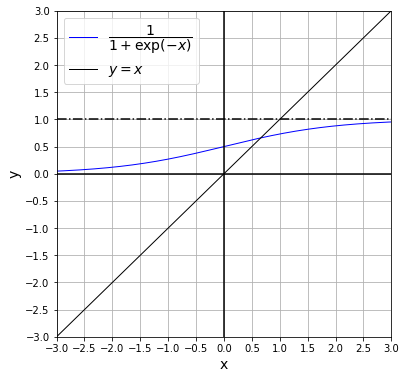

In [3]:
xx =  np.linspace(-6, 6, 500)
yy = 1 / (np.exp(-xx) + 1)

plt.figure(figsize=(6,6))
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.xticks(np.linspace(-3,3,13))
plt.yticks(np.linspace(-3,3,13))
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.grid()
plt.plot(xx, yy, c='b', label=r'$\dfrac{1}{1+\exp{(-x)}}$', lw=1)
plt.plot(xx, xx, c='k', label=r'$y = x$', lw=1)
plt.plot([-3,3], [0,0], c='k')
plt.plot([0,0], [-3,3],c='k')
plt.plot([-3,3],[1,1],linestyle='-.',c='k')
plt.legend(fontsize=14)
plt.show()

### データ準備

In [4]:
# 学習用データ準備
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


In [5]:
# データ絞り込み
#   クラス0, 1のみ
#   項目sepal_lengthとsepal_widthのみ
x_data, y_data = iris.data[:100,:2], iris.target[:100]
print('対象データ', x_data.shape, y_data.shape)

対象データ (100, 2) (100,)


In [6]:
# ダミー変数を追加
x_data = np.insert(x_data, 0, 1.0, axis=1)
print('ダミー変数追加後', x_data.shape)

ダミー変数追加後 (100, 3)


In [7]:
# 　元データのサイズ
print(x_data.shape, y_data.shape)
# 学習データ、検証データに分割 (シャフルも同時に実施)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 3) (100,)
(70, 3) (30, 3) (70,) (30,)


## 学習データと検証データ
モデルの精度を図るためによく使う手法

ー学習データを一定の比率で「学習用」「検証用」に分割（比率は決まリはないが、7対3や8対2が標準である。)
ー学習は「学習用」データを用いて行う
ーモデルの評価は「検証用」データを用いて行う

上記のコード「train_test_split」とはデータを学習用と検証用に分割するコード
元の１００件のデータをランダムにシャッフルした上で学習用70件、検証用３０件に分割する処理を行っている。

### 学習データの散布図表示

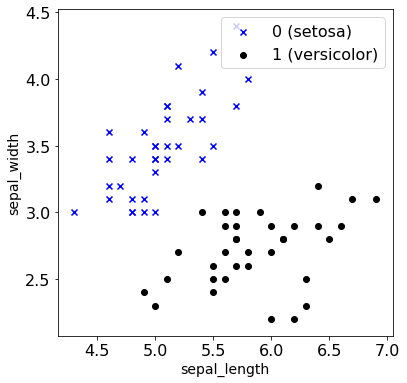

In [8]:
# 散布図の表示
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('sepal_width', fontsize=14)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

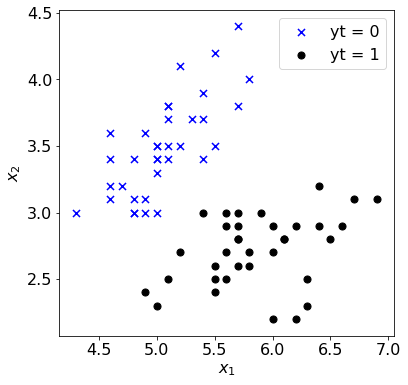

In [9]:
# 散布図の表示
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', s=50, c='b', label='yt = 0')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', s=50, c='k', label='yt = 1')
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$x_2$', fontsize=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

### 学習用変数の設定

#### 整備後の学習データ

In [10]:
# 学習用変数の設定
x = x_train
yt = y_train

In [11]:
# 入力データ x の表示 (ダミーデータを含む)
print(x[:5])

[[1.  5.1 3.7]
 [1.  5.5 2.6]
 [1.  5.5 4.2]
 [1.  5.6 2.5]
 [1.  5.4 3. ]]


In [12]:
# 正解値 yt の表示
print(yt[:5])

[0 1 0 1 1]


### 予測関数

In [13]:
# シグモイド関数
def sigmoid(x):
    return 1/(1+ np.exp(-x))

In [14]:
# 予測値の計算
def pred(x, w):
    return sigmoid(x @ w)

線形回帰の場合、内積の結果を予測値にしていたのに対し、
ロジスティック回帰では内積の結果をシグモイド関数かけてその結果を予測値として使っている。

### 評価

In [15]:
# 損失関数(交差エントロピー関数)
def cross_entropy(yt, yp):
    # 交差エントロピーの計算(この段階ではベクトル)
    ce1 = -(yt * np.log(yp) + (1 - yt) * np.log(1 - yp))
    # 交差エントロピーベクトルの平均値を計算
    return(np.mean(ce1)) 

In [16]:
# 予測結果の確率値から 0 or 1 を判断する関数
def classify(y):
    return np.where(y < 0.5, 0, 1)

In [17]:
# モデルの評価を行う関数
from sklearn.metrics import accuracy_score
def evaluate(xt, yt, w):
    
    # 予測値の計算
    yp = pred(xt, w)
    
    # 損失関数値の計算
    loss = cross_entropy(yt, yp)
    
    # 予測値(確率値)を0または1に変換
    yp_b = classify(yp)
    
    #精度の算出
    score = accuracy_score(yt, yp_b)
    return loss, score

### 初期化処理

In [18]:
# 初期化処理

# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む)
D = x.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 初期値
w = np.ones(D)

# 評価結果記録用 (損失関数と精度)
history = np.zeros((0,3))

### メイン処理

In [19]:
# 繰り返しループ

for k in range(iters):
    
    # 予測値の計算 (8.6.1) (8.6.2)
    yp = pred(x, w)
    
    # 誤差の計算 (8.6.4)
    yd = yp - yt
    
    # 勾配降下法の実施 (8.6.6)
    w = w - alpha * (x.T @ yd) / M
    
    # ログ記録用
    if ( k % 10 == 0):
        loss, score = evaluate(x_test, y_test, w)
        history = np.vstack((history, 
            np.array([k, loss, score])))
        print( "iter = %d  loss = %f score = %f" 
            % (k, loss, score))

iter = 0  loss = 4.493842 score = 0.500000
iter = 10  loss = 3.565375 score = 0.500000
iter = 20  loss = 2.643280 score = 0.500000
iter = 30  loss = 1.762444 score = 0.500000
iter = 40  loss = 1.085375 score = 0.500000
iter = 50  loss = 0.818721 score = 0.500000
iter = 60  loss = 0.770934 score = 0.500000
iter = 70  loss = 0.761053 score = 0.333333
iter = 80  loss = 0.754468 score = 0.200000
iter = 90  loss = 0.747781 score = 0.166667
iter = 100  loss = 0.740979 score = 0.133333
iter = 110  loss = 0.734193 score = 0.166667
iter = 120  loss = 0.727485 score = 0.200000
iter = 130  loss = 0.720875 score = 0.200000
iter = 140  loss = 0.714368 score = 0.266667
iter = 150  loss = 0.707967 score = 0.300000
iter = 160  loss = 0.701670 score = 0.366667
iter = 170  loss = 0.695476 score = 0.433333
iter = 180  loss = 0.689383 score = 0.500000
iter = 190  loss = 0.683389 score = 0.566667
iter = 200  loss = 0.677493 score = 0.700000
iter = 210  loss = 0.671693 score = 0.700000
iter = 220  loss = 0.

iter = 3050  loss = 0.238620 score = 0.966667
iter = 3060  loss = 0.238261 score = 0.966667
iter = 3070  loss = 0.237904 score = 0.966667
iter = 3080  loss = 0.237550 score = 0.966667
iter = 3090  loss = 0.237197 score = 0.966667
iter = 3100  loss = 0.236846 score = 0.966667
iter = 3110  loss = 0.236497 score = 0.966667
iter = 3120  loss = 0.236150 score = 0.966667
iter = 3130  loss = 0.235805 score = 0.966667
iter = 3140  loss = 0.235461 score = 0.966667
iter = 3150  loss = 0.235120 score = 0.966667
iter = 3160  loss = 0.234780 score = 0.966667
iter = 3170  loss = 0.234443 score = 0.966667
iter = 3180  loss = 0.234107 score = 0.966667
iter = 3190  loss = 0.233772 score = 0.966667
iter = 3200  loss = 0.233440 score = 0.966667
iter = 3210  loss = 0.233109 score = 0.966667
iter = 3220  loss = 0.232780 score = 0.966667
iter = 3230  loss = 0.232453 score = 0.966667
iter = 3240  loss = 0.232128 score = 0.966667
iter = 3250  loss = 0.231804 score = 0.966667
iter = 3260  loss = 0.231482 score

iter = 6790  loss = 0.172834 score = 0.966667
iter = 6800  loss = 0.172748 score = 0.966667
iter = 6810  loss = 0.172663 score = 0.966667
iter = 6820  loss = 0.172578 score = 0.966667
iter = 6830  loss = 0.172494 score = 0.966667
iter = 6840  loss = 0.172409 score = 0.966667
iter = 6850  loss = 0.172325 score = 0.966667
iter = 6860  loss = 0.172241 score = 0.966667
iter = 6870  loss = 0.172157 score = 0.966667
iter = 6880  loss = 0.172073 score = 0.966667
iter = 6890  loss = 0.171990 score = 0.966667
iter = 6900  loss = 0.171907 score = 0.966667
iter = 6910  loss = 0.171824 score = 0.966667
iter = 6920  loss = 0.171741 score = 0.966667
iter = 6930  loss = 0.171659 score = 0.966667
iter = 6940  loss = 0.171577 score = 0.966667
iter = 6950  loss = 0.171495 score = 0.966667
iter = 6960  loss = 0.171413 score = 0.966667
iter = 6970  loss = 0.171332 score = 0.966667
iter = 6980  loss = 0.171250 score = 0.966667
iter = 6990  loss = 0.171169 score = 0.966667
iter = 7000  loss = 0.171088 score

### 結果確認

In [20]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
      % (history[0,1], history[0,2]))
print('最終状態: 損失関数:%f 精度:%f' 
      % (history[-1,1], history[-1,2]))

初期状態: 損失関数:4.493842 精度:0.500000
最終状態: 損失関数:0.153947 精度:0.966667


In [21]:
# 検証データを散布図用に準備
x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

# 決定境界描画用 x1の値から x2の値を計算する
def b(x, w):
    return(-(w[0] + w[1] * x)/ w[2])
# 散布図のx1の最小値と最大値
xl = np.asarray([x[:,1].min(), x[:,1].max()])
yl = b(xl, w)

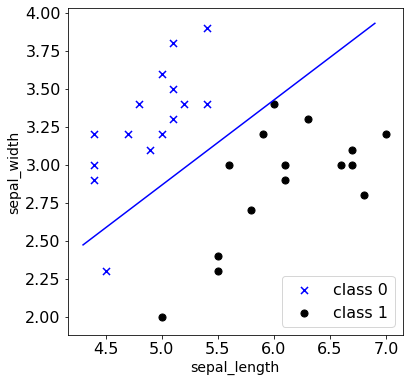

In [22]:
plt.figure(figsize=(6,6))
# 散布図の表示
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', 
        c='k', s=50, label='class 1')
# 散布図に決定境界の直線も追記
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('sepal_width', fontsize=14)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

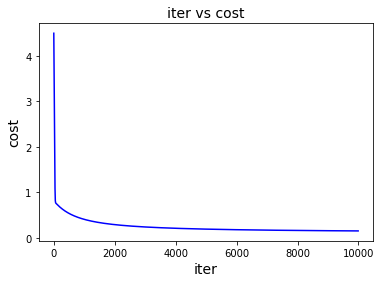

In [23]:
# 学習曲線の表示をします (損失関数)
plt.figure(figsize=(6,4))
plt.plot(history[:,0], history[:,1], 'b')
plt.xlabel('iter', fontsize=14)
plt.ylabel('cost', fontsize=14)
plt.title('iter vs cost', fontsize=14)
plt.show()

## 損失関数が順調に減っていることがわかる

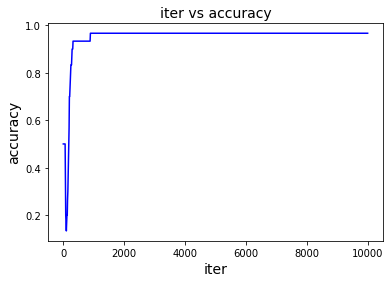

In [24]:
# 学習曲線の表示をします (精度)
plt.figure(figsize=(6,4))
plt.plot(history[:,0], history[:,2], 'b')
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

上記のグラフは精度を縦軸に取った場合のグラフ、100%にならないのは、散布図表示でわかった異常値があるところによる。
良い精度を持っていると考えられる。

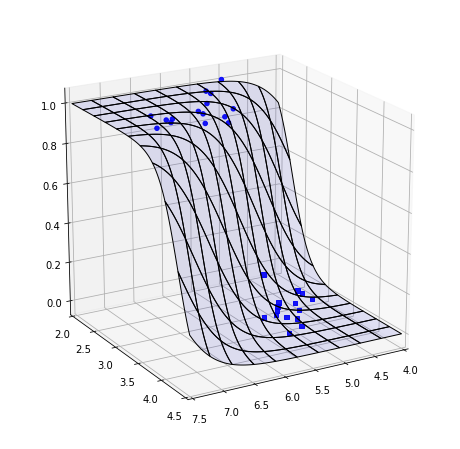

In [25]:
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 7.5, 100)
x2 = np.linspace(2, 4.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.asarray([np.ones(xx1.ravel().shape), 
    xx1.ravel(), xx2.ravel()]).T
c = pred(xxx, w).reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c, color='blue', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.1)
ax.scatter(x_t1[:,1], x_t1[:,2], 1, s=20, alpha=0.9, marker='o', c='b')
ax.scatter(x_t0[:,1], x_t0[:,2], 0, s=20, alpha=0.9, marker='s', c='b')
ax.set_xlim(4,7.5)
ax.set_ylim(2,4.5)
ax.view_init(elev=20, azim=60)

(w0, w1, w2)の値を使ってシグモイド関数の値を3次元的に表示し、元の入力データの値（Z座標は1または0の正解値にしている)も重ね書きしたグラフの結果を示す

## scikit-learnライブラリの利用

In [26]:
# 必要ライブラリのロード
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# モデル生成
model_lr = LogisticRegression(solver='liblinear')
model_svm = svm.SVC(kernel='linear')

# 機械学習実施
model_lr.fit(x, yt)
model_svm.fit(x, yt)

SVC(kernel='linear')

In [27]:
# 線形回帰
# 切片の値
lr_w0 = model_lr.intercept_[0]
# x1(sepal_length)の係数
lr_w1 = model_lr.coef_[0,1]
# x2(sepal_width)の係数
lr_w2 = model_lr.coef_[0,2]

# SVM
# 切片の値
svm_w0 = model_svm.intercept_[0]
# x1(sepal_length)の係数
svm_w1 = model_svm.coef_[0,1]
# x2(sepal_width)の係数
svm_w2 = model_svm.coef_[0,2]

In [28]:
# 限界直線描画用 x1の値から x2の値を計算する
def rl(x):
    wk = lr_w0 + lr_w1 * x
    wk2 = -wk / lr_w2
    return(wk2)

In [29]:
# 限界直線描画用 x1の値から x2の値を計算する
def svm(x):
    wk = svm_w0 + svm_w1 * x
    wk2 = -wk / svm_w2
    return(wk2)

In [30]:
y_rl = rl(xl)
y_svm = svm(xl)
# 結果確認
print(xl, yl, y_rl, y_svm)

[4.3 6.9] [2.47353128 3.93052473] [2.50344682 4.05984593] [2.17911792 4.42574136]


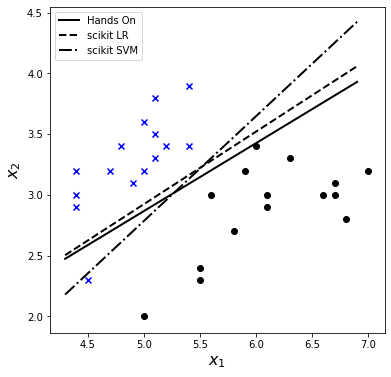

In [31]:
# 散布図に限界直線も追記する
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
# 散布図の表示
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', c='b')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', c='k')
# 限界直線の表示
ax.plot(xl, yl, linewidth=2, c='k', label='Hands On')
# lr model
ax.plot(xl, y_rl, linewidth=2, c='k', linestyle="--", label='scikit LR')
# svm
ax.plot(xl, y_svm, linewidth=2, c='k', linestyle="-.", label='scikit SVM')

ax.legend()
ax.set_xlabel('$x_1$', fontsize=16)
ax.set_ylabel('$x_2$', fontsize=16)
plt.show()